In [2]:
import os
import coastalcf as clf
from esa_snappy import ProductIO, GPF
from esa_snappy import GPF, HashMap, jpy
import numpy as np
import seaborn as sns

import pandas as pd
import xarray as xr     
import matplotlib.pyplot as plt
import matplotlib.dates as mdates   


---------------------------------------------------------------------------
***************************************************************************
---------------------------------------------------------------------------
//////////////////        PREPARACIÓN DE LOS DATOS        /////////////////
---------------------------------------------------------------------------
***************************************************************************
---------------------------------------------------------------------------

In [ ]:
# --- 1. Define la región de interés (ROI) para el subconjunto y la ruta del producto.
# Si no existew substet colocar None
# x = y = width = height = None
#Inicio de la región de interés (ROI) en coordenadas de píxeles.
x= 20300
y =6900
#Final de la región de interés (ROI) en coordenadas de píxeles.
width = 3238
height = 3228




#x = y = width = height = None

# Defininir parámetros para el operador GLCM.
para = {'sourceBands': 'VH'}

# Path del Producto de Sentinel 1 y ouput de archivos.

sentinel_1_path = r'C:\1_ENSOCE\C2_Data\2023\S1A_IW_GRDH_1SDV_20230801T125812_20230801T125837_049682_05F965_72CB'
sentinel_id = clf.get_sentinel_fecha_id(sentinel_1_path)
output_directory = r'C:\1_ENSOCE\C3_Output\2023\8_agosto'
output_directorysh = r'C:\1_ENSOCE\C3_Output\2023\8_agosto\shape'


"""
x= 20229
y = 8895
width = 1190
height = 1190
#---------------
x= 20654
y = 9194
width = 870
height = 870
#---------------
x= 21334
y = 8404
width = 600
height = 600
#---------------
x= 10300
y = 5300
width = 14884
height = 11415
"""

'\nx= 20229\ny = 8895\nwidth = 1190\nheight = 1190\n#---------------\nx= 20654\ny = 9194\nwidth = 870\nheight = 870\n#---------------\nx= 21334\ny = 8404\nwidth = 600\nheight = 600\n#---------------\nx= 10300\ny = 5300\nwidth = 14884\nheight = 11415\n'

import os
import glob
from coastalcf.wbplots import aplicar_correccion_y_grid

# Ruta base
base_input = r'C:\1_ENSOCE\C2_Data\2022'
base_output = r'C:\1_ENSOCE\C3_Output\2022'

meses_output = [
    '1_enero', '2_febrero', '3_marzo', '4_abril', '5_mayo', '6_junio',
    '7_julio', '8_agosto', '9_septiembre', '10_octubre', '11_noviembre', '12_diciembre'
]

for i in range(1, 13):
    input_folder = os.path.join(base_input, f'2022_{i:02d}')
    output_directory = os.path.join(base_output, meses_output[i - 1])
    output_directorysh = os.path.join(output_directory, 'sh')
    os.makedirs(output_directory, exist_ok=True)
    os.makedirs(output_directorysh, exist_ok=True)

    files = glob.glob(os.path.join(input_folder, "1A_IW_GRDH_1SDV_*"))
    if not files:
        print(f"  No se encontró archivo Sentinel-1 en {input_folder}")
        continue

    sentinel_1_path = files[0]
    print(f" Procesando: {sentinel_1_path}")

    sentinel_id = clf.get_sentinel_fecha_id(sentinel_1_path)

    product = clf.readMetadata(sentinel_1_path, toPrint=True)
    thermaremoved = clf.do_thermal_noise_removal(product)
    if thermaremoved is None: raise RuntimeError("Thermal noise removal failed.")

    calibrate = clf.radiometricCalibration(thermaremoved)
    if calibrate is None: raise RuntimeError("Radiometric calibration failed.")

    valid_bands = list(calibrate.getBandNames())
    subset_bands = [band for band in ['Sigma0_VH', 'Sigma0_VV', 'Beta0_VH', 'Beta0_VV'] if band in valid_bands]
    if not subset_bands: raise RuntimeError("No existen Bandas válidas para el subset.")

    subset_product = clf.subset(calibrate, x, y, width, height, subset_bands)
    if subset_product is None or subset_product.getSceneRasterWidth() == 0:
        raise RuntimeError("El subset no contiene datos válidos.")

    multilook = clf.perform_multilook(subset_product)
    if multilook is None: raise RuntimeError("Multilooking failed.")

    speckle = clf.speckleFiltering(multilook, toPrint=True)
    if speckle is None: raise RuntimeError("Speckle filtering failed.")

    terrain1 = clf.perform_terrain_flattening(speckle)
    if terrain1 is None: raise RuntimeError("Terrain flattening failed.")

    output_path_terrain = os.path.join(output_directory, "terrain1")
    # ProductIO.writeProduct(terrain1, output_path_terrain, "GeoTIFF")

    textura = clf.glcmOp().glcm(terrain1, para)
    if textura is None: raise RuntimeError("GLCM texture calculation failed.")

    output_path_glcm = os.path.join(output_directory, "glcm")
    glcmc = clf.geometricCorrection(textura, toPrint=True)
    # ProductIO.writeProduct(glcmc, output_path_glcm, "GeoTIFF")

    # === 8. Umbralización (WDBThreshold)
    print("Performing water detection...")
    productos_binarios, umbrales, img_db_valid, extent = clf.WDBThreshold(
        textura=textura,
        sentinel_1_path=sentinel_1_path,
        window_size=15,
        k=0.2,
        r=None,
        output_dir=output_directory
    )

    productos_para_graficar = {
        "flood_otsu": (productos_binarios["flood_otsu"], umbrales["otsu"]),
        "flood_niblack": (productos_binarios["flood_niblack"], umbrales["niblack"]),
        "flood_sauvola": (productos_binarios["flood_sauvola"], umbrales["sauvola"]),
        "flood_MCET": (productos_binarios["flood_MCET"], umbrales["MCET"]),
        "flood_MCET_iter": (productos_binarios["flood_MCET_iter"], umbrales["MCET_iterativo"]),
    }

    # === 9. Corrección geométrica
    print("Applying terrain correction to all thresholded products...")
    productos_binarios_corrected = {}
    for nombre, (producto, threshold) in productos_para_graficar.items():
        print(f" -> Corrigiendo: {nombre}")
        corregido = clf.geometricCorrection(producto, toPrint=True)
        if corregido is None:
            print(f"  No se pudo corregir el producto: {nombre}")
        else:
            productos_binarios_corrected[nombre] = (corregido, threshold)

    img_db_product = clf.geometricCorrection(img_db_valid, toPrint=True)

    # === 10. Visualización
    print("\nCreando producto SNAP para img_db_valid...")
    aplicar_correccion_y_grid(
        productos_binarios=productos_binarios_corrected,
        output_directory=output_directory,
        sentinel_id=sentinel_id,
        img_db_product=img_db_product,
        vh_extent=extent
    )

---------------------------------------------------------------------------
***************************************************************************
---------------------------------------------------------------------------
///////////////// APLICACIÓN DE LOS PASOS DE PROCESAMIENTO ////////////////
---------------------------------------------------------------------------
***************************************************************************
---------------------------------------------------------------------------

In [3]:
# --- 1. Lectura de metadatos del producto Sentinel-1 ---
product = clf.readMetadata(sentinel_1_path, toPrint=True)  

# --- 2. Eliminación de ruido térmico : do_thermal_noise_removal [output]---
thermaremoved = clf.do_thermal_noise_removal(product)
if thermaremoved is None:
    raise RuntimeError("Thermal noise removal failed.")
print(f"Bands after ThermalNoiseRemoval: {list(thermaremoved.getBandNames())}")
#**************************************************************************
# --- 3. Calibración radiométrica : radiometricCalibration [calibrated] ---
calibrate = clf.radiometricCalibration(thermaremoved)
if calibrate is None:
    raise RuntimeError("Radiometric calibration failed.")
print(f"Bands after RadiometricCalibration: {list(calibrate.getBandNames())}")

# - Verificar las bandas después de la calibración
valid_bands = list(calibrate.getBandNames())
print(f" Bandas disponibles después de la calibración: {valid_bands}")

# - Asegurar que usamos solo las bandas que existen
subset_bands = [band for band in ['Sigma0_VH', 'Sigma0_VV', 'Beta0_VH', 'Beta0_VV'] if band in valid_bands]
if not subset_bands:
    raise RuntimeError("No existen Bandas válidas para el subset.")
# ---
# --- Paso 3.1: Crear el subset después de calibrar ---

subset_product = clf.subset(calibrate, x, y, width, height, subset_bands)

# - Validar subset antes de continuar
if subset_product is None or subset_product.getSceneRasterWidth() == 0 or subset_product.getSceneRasterHeight() == 0:
    raise RuntimeError("Error: El subset no contiene datos válidos.")

print(f" Subset creado correctamente con bandas: {list(subset_product.getBandNames())}")
print(subset_product.getMetadataRoot().toString())
#**************************************************************************
# --- 4. Aplicación de multilooking : perform_multilook [multilook]
print("Performing multilooking...")
#multilook = perform_multilook(calibrate)
multilook = clf.perform_multilook(subset_product)
if multilook is None:
    raise RuntimeError("Multilooking failed.")
#**************************************************************************
# --- 5. Filtrado de speckle : speckleFiltering [speckle]
print("Applying speckle filtering...")
speckle = clf.speckleFiltering(multilook, toPrint=True)
if speckle is None:
    raise RuntimeError("Speckle filtering failed.")


#**************************************************************************
# --- 6. Nivelación del terreno (Terrain Flattening) : perform_terrain_flattening [terrain]
print("Applying terrain flattening...")
terrain1 = clf.perform_terrain_flattening(speckle)
if terrain1 is None:
    raise RuntimeError("Terrain flattening failed.")

# Guardar el producto completo, con todas sus bandas
output_path_terrain = os.path.join(output_directory, "terrain1")
#ProductIO.writeProduct(terrain1, output_path_terrain, "GeoTIFF")
#******************x********************************************************
# --- 7. Cálculo de texturas GLCM : glcmOp / glcm [textura]
print("Calculating texture...")
textura = clf.glcmOp().glcm(terrain1, para)
if textura is None:
    raise RuntimeError("GLCM texture calculation failed.")
# Guardar el producto completo, con todas sus bandas
output_path_terrain = os.path.join(output_directory, "glcm")
glcmc = clf.geometricCorrection(textura, toPrint=True)
#ProductIO.writeProduct(glcmc, output_path_terrain, "GeoTIFF")
#!!!!!!!!!!!!!!!!!!!!!
#**************************************************************************


Producto: S1A_IW_GRDH_1SDV_20230801T125812_20230801T125837_049682_05F965_72CB, 25957 x 16715 píxeles
Bandas:   ['Amplitude_VH', 'Intensity_VH', 'Amplitude_VV', 'Intensity_VV']
	Eliminando ruido térmico...
Bands after ThermalNoiseRemoval: ['Intensity_VH', 'Intensity_VV']
	Aplicando calibración radiométrica...
Bands after RadiometricCalibration: ['Sigma0_VH', 'Beta0_VH']
 Bandas disponibles después de la calibración: ['Sigma0_VH', 'Beta0_VH']
Bandas en el subset: ['Sigma0_VH', 'Beta0_VH']
 Subset creado correctamente con bandas: ['Sigma0_VH', 'Beta0_VH']
org.esa.snap.core.datamodel.MetadataElement[name=metadata]
Performing multilooking...
	Aplicando Multilooking: RgLooks=1, AzLooks=1, Pixel=10m, Intensidad=False
Applying speckle filtering...
	Bandas del producto filtrado: ['Sigma0_VH', 'Beta0_VH']
Applying terrain flattening...
	Aplicando nivelación del terreno...
Calculating texture...
GLCM: Estableciendo parámetros...
GLCM: Creando producto GLCM...
org.esa.snap.core.datamodel.Product[n

Performing water detection...

--- Iniciando detección de agua con TODOS los métodos ---
Bandas disponibles: ['Gamma0_VH_GLCMMean']
Rango de datos lineales: -9999.0 254.0
Rango de datos lineales: -9999.0 254.0
Convirtiendo a escala de decibeles (dB)...
Conversión a dB completada.
Extent: [-106.33050636165592, -106.69691691141645, 23.212846440576826, 23.452253341674805]
Rango de valores en dB: Min=-0.31, Max=24.05
Calculando umbrales (Otsu, Niblack, Sauvola, Li)...


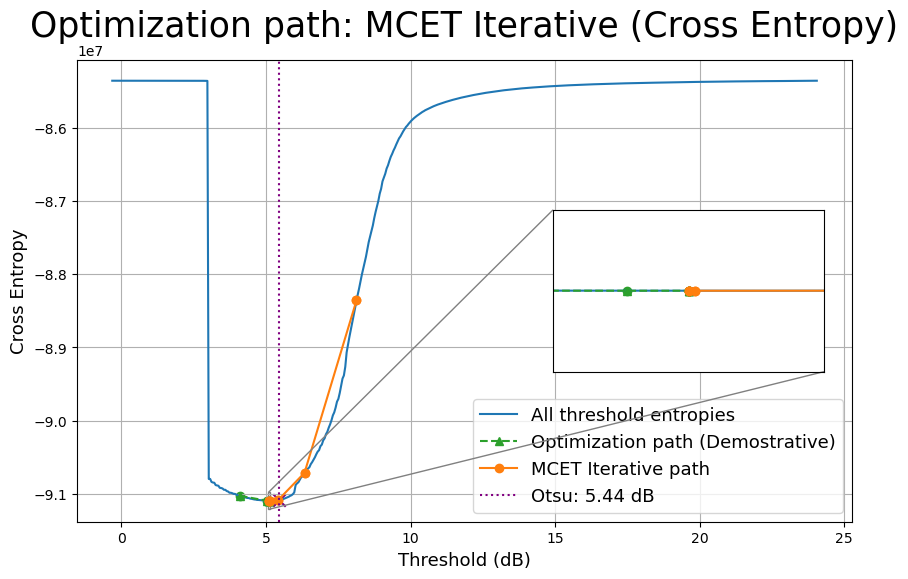

Threshold inicial de Li: 5.13247013092041
Threshold optimizado de Li Iterativo: 5.10980224609375
  - Otsu         = 5.445
  - Niblack      = 4.955
  - Sauvola      = 4.702
  - Li           = 5.132
  - Li iterativo = 5.110
Creando producto individual para: flood_otsu
Producto creado: flood_otsu
Creando producto individual para: flood_niblack
Producto creado: flood_niblack
Creando producto individual para: flood_sauvola
Producto creado: flood_sauvola
Creando producto individual para: flood_MCET
Producto creado: flood_MCET
Creando producto individual para: flood_MCET_iter
Producto creado: flood_MCET_iter

Creando producto SNAP para img_db_valid...
Producto SNAP para img_db_valid creado exitosamente.


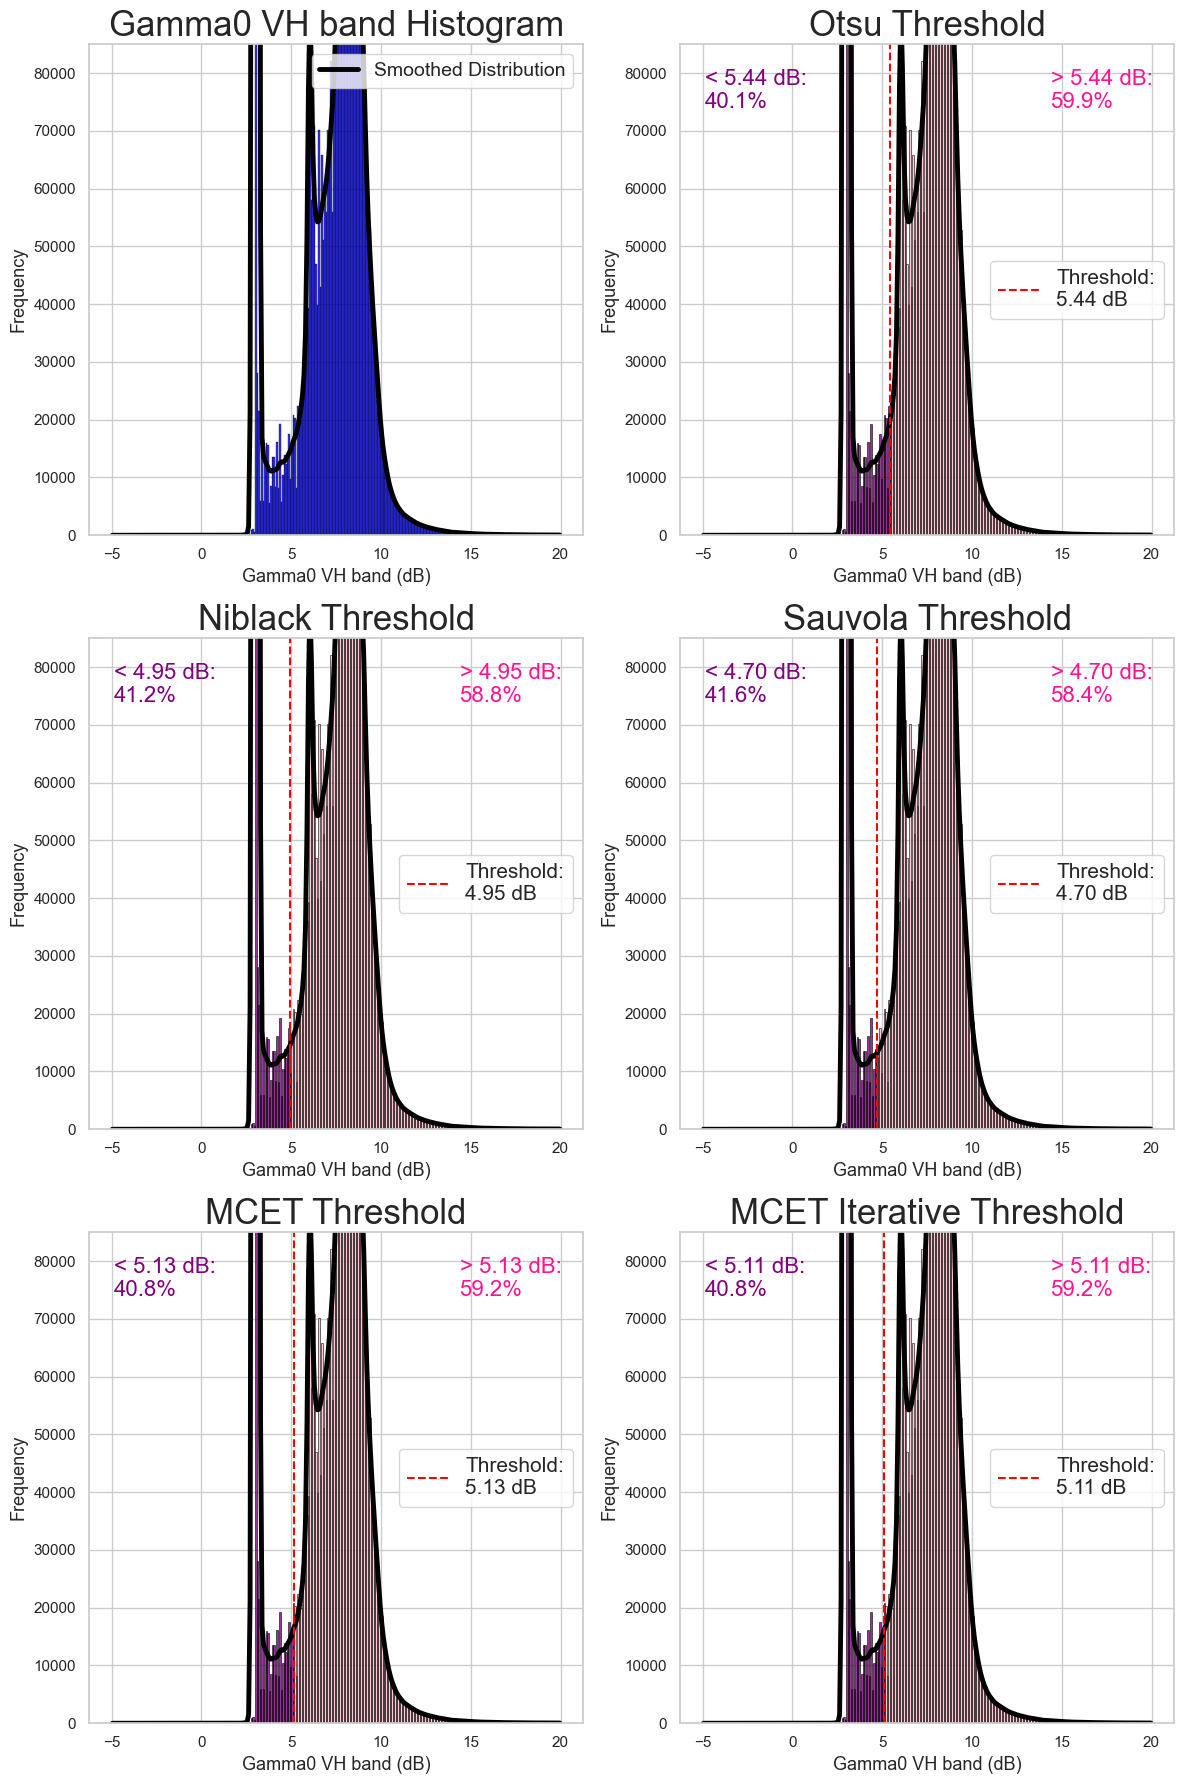

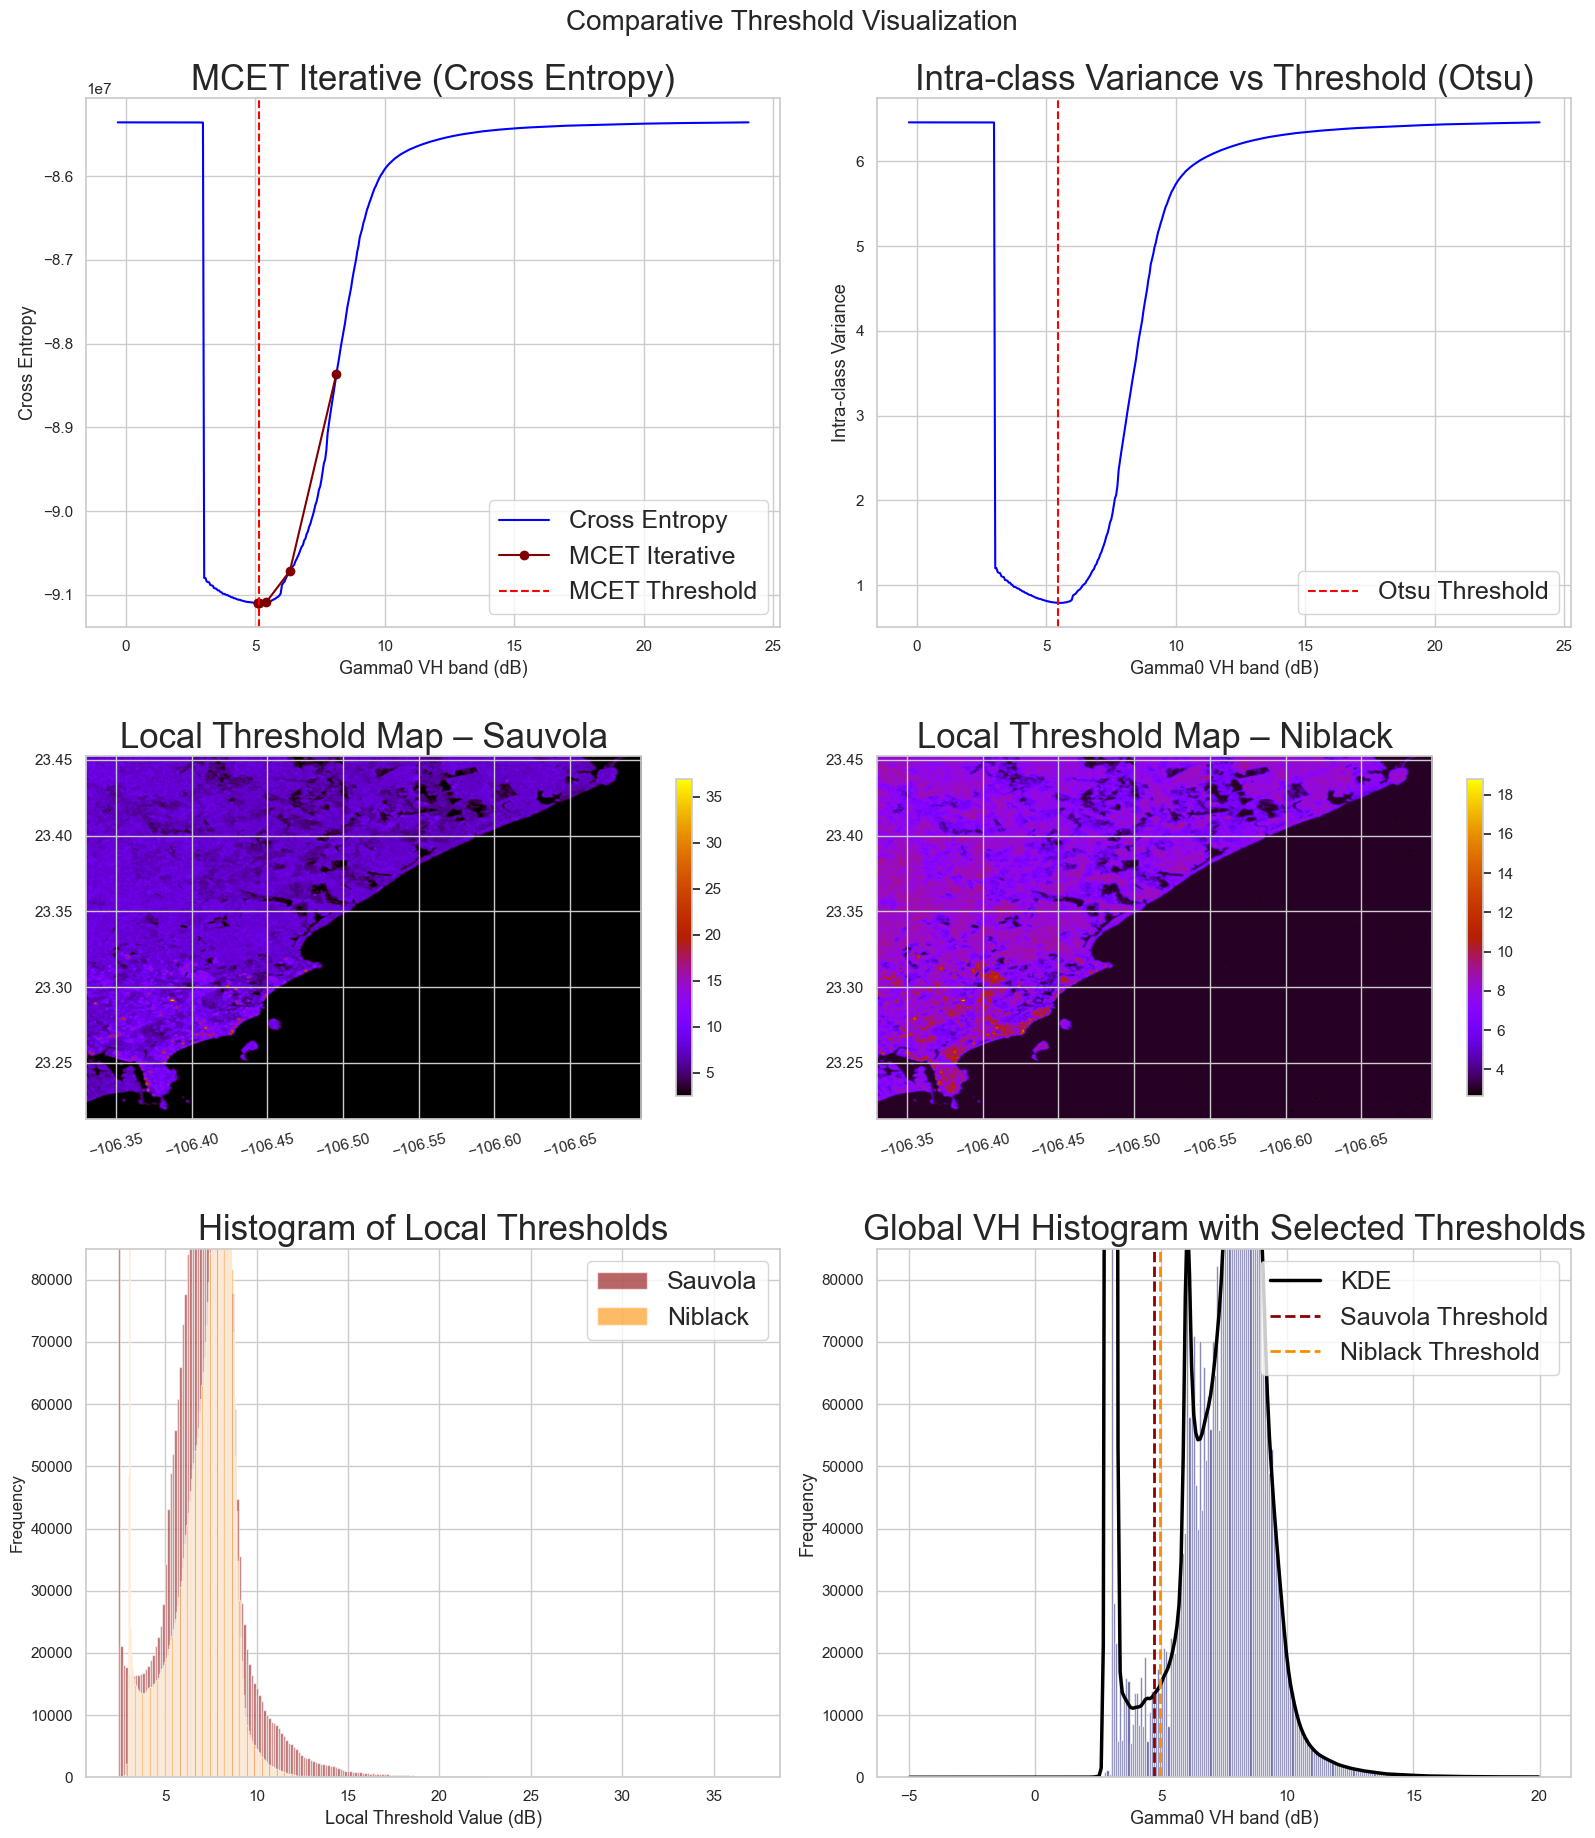

In [4]:
#**************************************************************************

# 8. Umbralización (Método Sauvola) : waterDetectionBinarization [product]
print("Performing water detection...")
productos_binarios, umbrales, img_db_valid, extent = clf.WDBThreshold(
    textura=textura,
    sentinel_1_path=sentinel_1_path,
    window_size=15,
    k=0.2,     # extra param para Niblack/Sauvola
    r=None,     # extra param para Sauvola
    output_dir= output_directory
)

productos_para_graficar = {
    "flood_otsu": (productos_binarios["flood_otsu"], umbrales["otsu"]),
    "flood_niblack": (productos_binarios["flood_niblack"], umbrales["niblack"]),
    "flood_sauvola": (productos_binarios["flood_sauvola"], umbrales["sauvola"]),
    "flood_MCET": (productos_binarios["flood_MCET"], umbrales["MCET"]),
    "flood_MCET_iter": (productos_binarios["flood_MCET_iter"], umbrales["MCET_iterativo"]),
}
#**************************************************************************


In [5]:
clf.get_sentinel_fecha_id

<function coastalcf.get_sentinel_fecha_id.get_sentinel_fecha_id(sentinel_path)>

Applying terrain correction to all thresholded products...
 -> Corrigiendo: flood_otsu

--- Iniciando corrección geométrica ---
NoData asignado a banda 'flood_otsu' con valor: -1.0
Aplicando corrección geométrica...
Corrección geométrica completada exitosamente.
NoData asignado a banda corregida 'flood_otsu_VH' con valor: -1.0
Bandas resultantes: ['flood_otsu_VH']
Proceso de corrección geométrica finalizado.
 -> Corrigiendo: flood_niblack

--- Iniciando corrección geométrica ---
NoData asignado a banda 'flood_niblack' con valor: -1.0
Aplicando corrección geométrica...
Corrección geométrica completada exitosamente.
NoData asignado a banda corregida 'flood_niblack_VH' con valor: -1.0
Bandas resultantes: ['flood_niblack_VH']
Proceso de corrección geométrica finalizado.
 -> Corrigiendo: flood_sauvola

--- Iniciando corrección geométrica ---
NoData asignado a banda 'flood_sauvola' con valor: -1.0
Aplicando corrección geométrica...
Corrección geométrica completada exitosamente.
NoData asigna

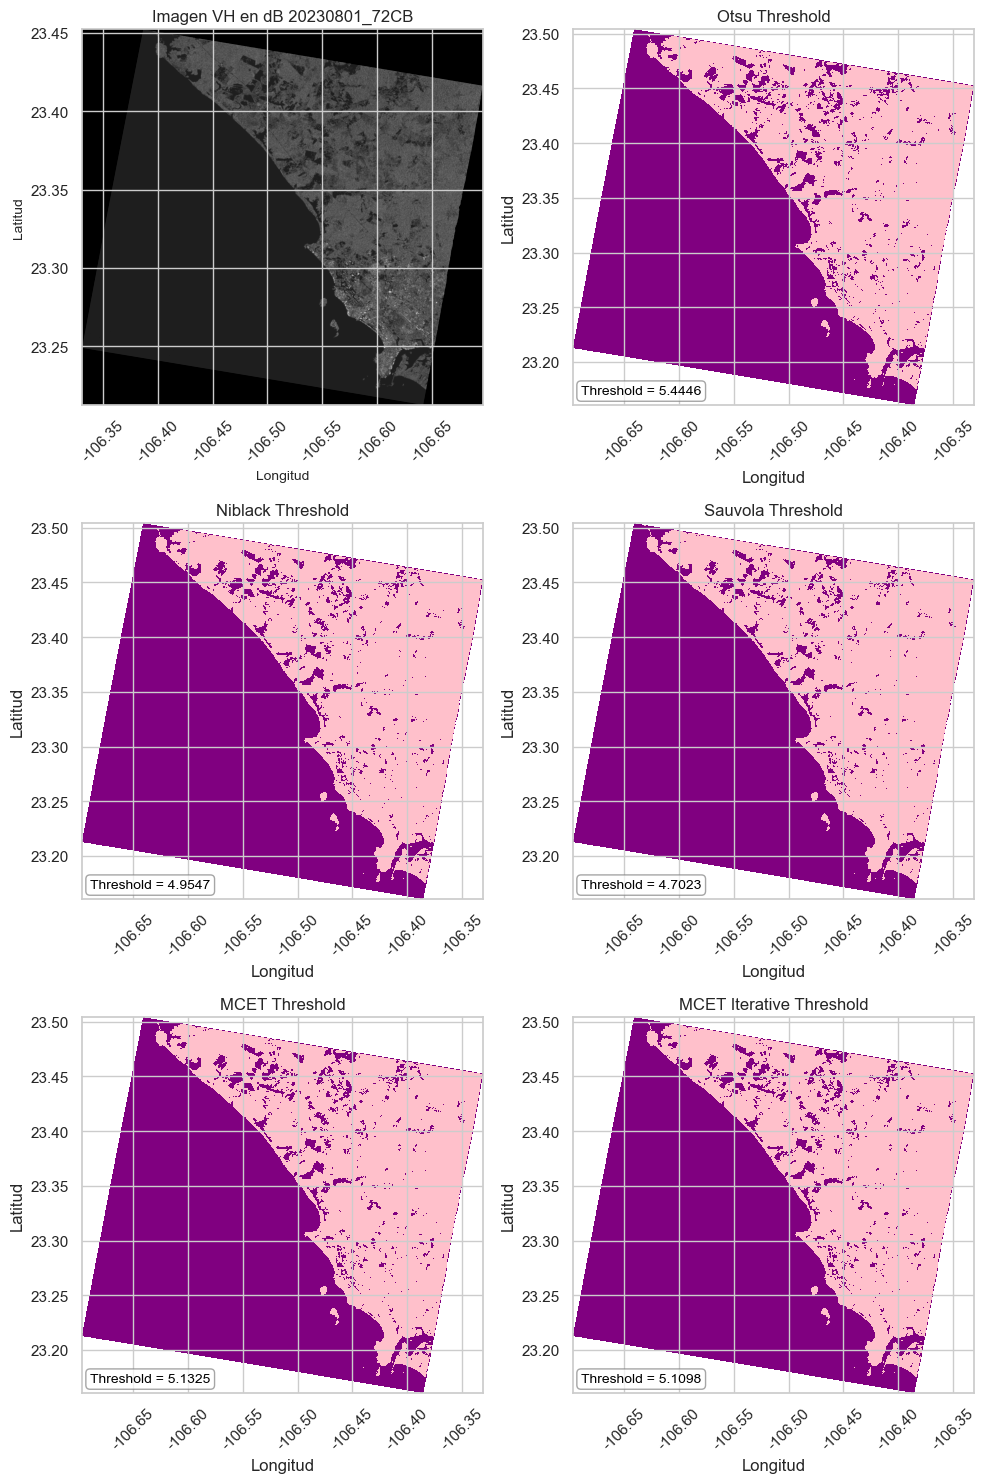

✅ Exportado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C3_Output\2023\8_agosto\VH_flood_otsu_filtered.tif
✅ Exportado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C3_Output\2023\8_agosto\VH_flood_niblack_filtered.tif
✅ Exportado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C3_Output\2023\8_agosto\VH_flood_sauvola_filtered.tif
✅ Exportado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C3_Output\2023\8_agosto\VH_flood_MCET_filtered.tif
✅ Exportado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C3_Output\2023\8_agosto\VH_flood_MCET_iter_filtered.tif


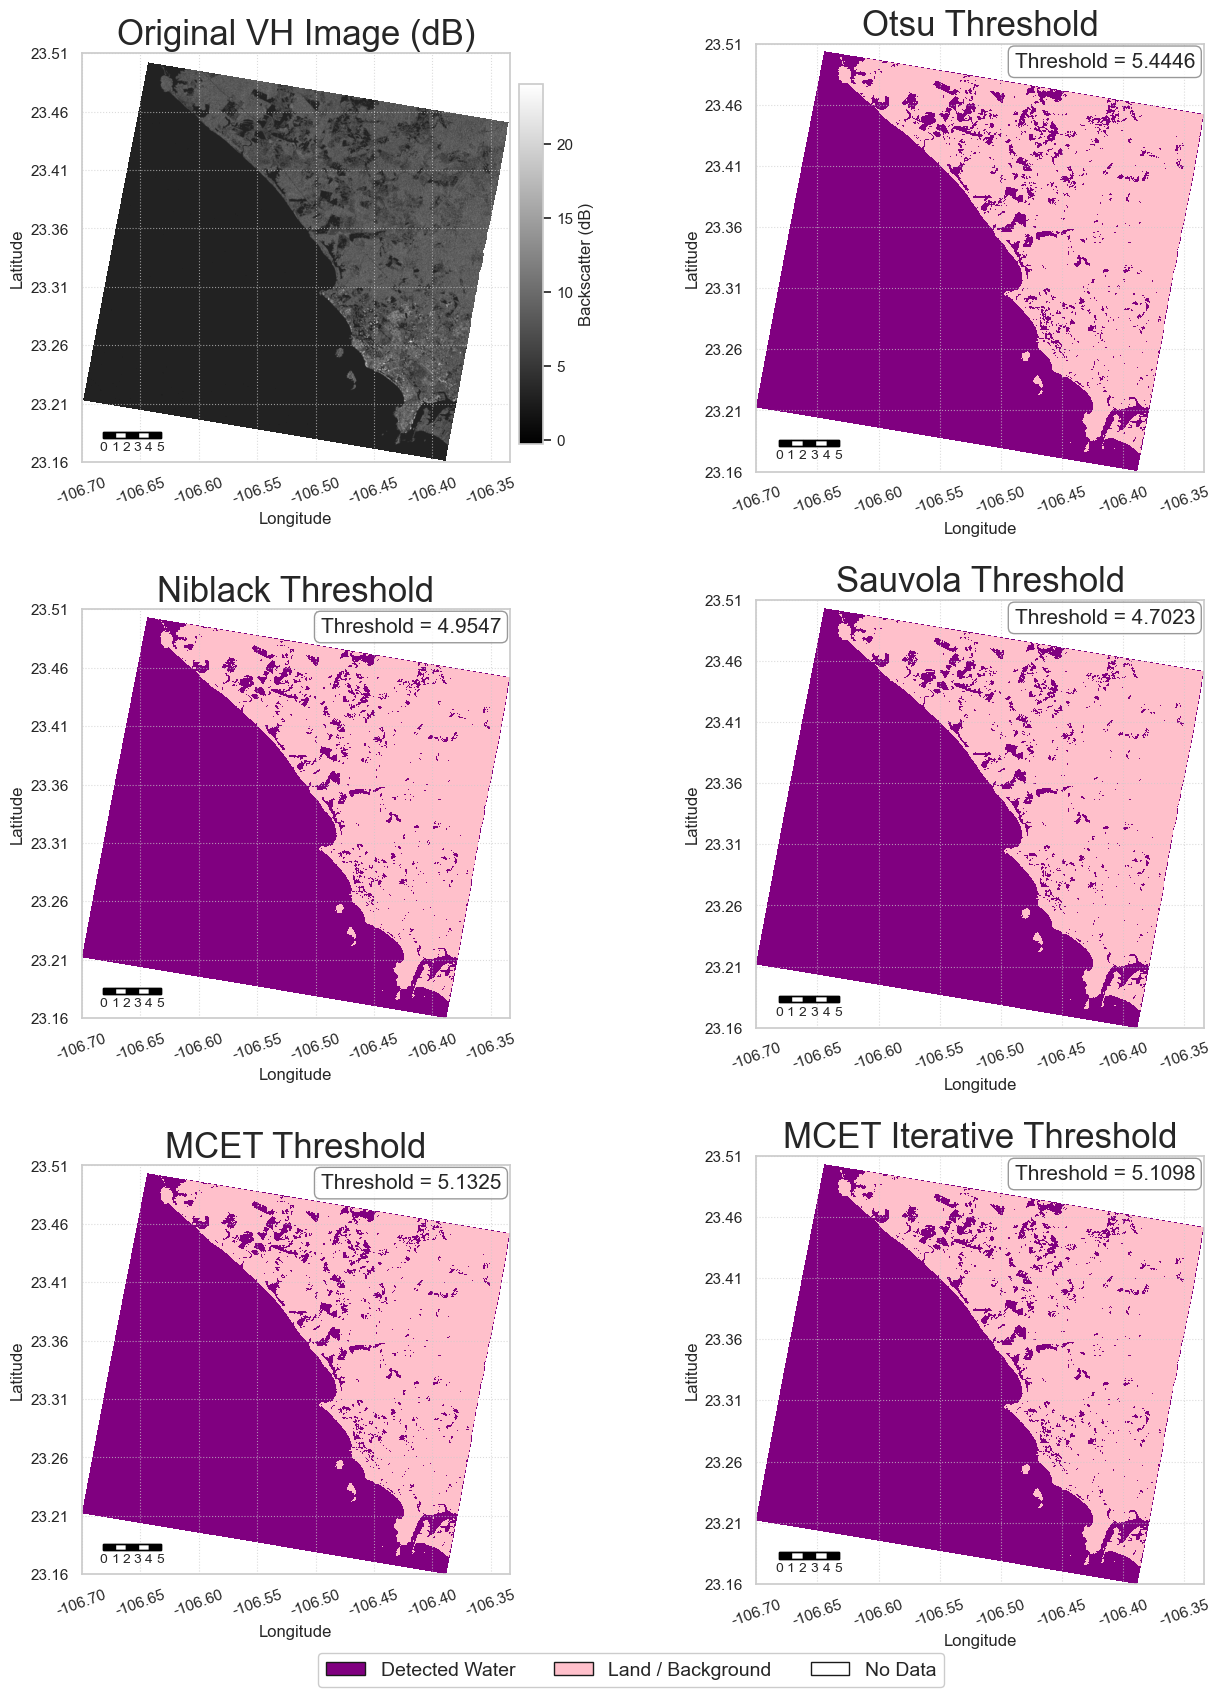

In [ ]:
#**************************************************************************
import coastalcf as clf

    
sentinel_id = clf.get_sentinel_fecha_id(sentinel_1_path)

# 9. Corrección geométrica: geometricCorrection [corrected]

print("Applying terrain correction to all thresholded products...")

productos_binarios_corrected = {}
for nombre, (producto, threshold) in productos_para_graficar.items():
    print(f" -> Corrigiendo: {nombre}")
    corregido = clf.geometricCorrection(producto, toPrint=True)
    if corregido is None:
        print(f"⚠️  No se pudo corregir el producto: {nombre}")
    else:
        productos_binarios_corrected[nombre] = (corregido, threshold)

img_db_product = clf.geometricCorrection(img_db_valid, toPrint=True)


# 10. Visualización en grid de productos corregidosprint("\nCreando producto SNAP para img_db_valid...")

from coastalcf.wbplots import aplicar_correccion_y_grid
#aplicar_correccion_y_grid(productos_binarios_corrected, output_directory, sentinel_id)
aplicar_correccion_y_grid(
    productos_binarios=productos_binarios_corrected, 
    output_directory=output_directory,
    sentinel_id=sentinel_id,
    img_db_product=img_db_product,  # <- tu imagen VH ya en dB
    vh_extent=extent  # <- opcional si quieres respetar georeferencia
    )

# 10. Visualización en grid de productos corregidos - 
#NOTA: Descomentar la parte de ThresholdsPlots cen caso de necesitar guardar los demas TIFF
clf.ThresholdsPlots(img_db_product=img_db_product, productos_binarios_corrected=productos_binarios_corrected,
                                output_directory=output_directory, object_size=15, sentinel_id="VH")

In [7]:
1=2

SyntaxError: cannot assign to literal (3293032332.py, line 1)

In [ ]:
productos_binarios_corrected
print("Claves disponibles:", productos_binarios_corrected.keys())


Claves disponibles: dict_keys(['flood_otsu', 'flood_niblack', 'flood_sauvola', 'flood_MCET', 'flood_MCET_iter'])


In [ ]:
primer_producto = next(iter(productos_para_graficar.values()))[0]
print("Bandas disponibles:", list(primer_producto.getBandNames()))


Bandas disponibles: ['flood_otsu']


In [ ]:
for nombre, (producto, umbral) in productos_binarios_corrected.items():
    bandas = list(producto.getBandNames())
    print(f"{nombre} → Bandas disponibles: {bandas}")


flood_otsu → Bandas disponibles: ['flood_otsu_VH']
flood_niblack → Bandas disponibles: ['flood_niblack_VH']
flood_sauvola → Bandas disponibles: ['flood_sauvola_VH']
flood_MCET → Bandas disponibles: ['flood_MCET_VH']
flood_MCET_iter → Bandas disponibles: ['flood_MCET_iter_VH']


✅ Exportado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C3_Output\2023\8_agosto\VH_flood_otsu_filtered.tif
✅ Exportado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C3_Output\2023\8_agosto\VH_flood_niblack_filtered.tif
✅ Exportado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C3_Output\2023\8_agosto\VH_flood_sauvola_filtered.tif
✅ Exportado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C3_Output\2023\8_agosto\VH_flood_MCET_filtered.tif
✅ Exportado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C3_Output\2023\8_agosto\VH_flood_MCET_iter_filtered.tif


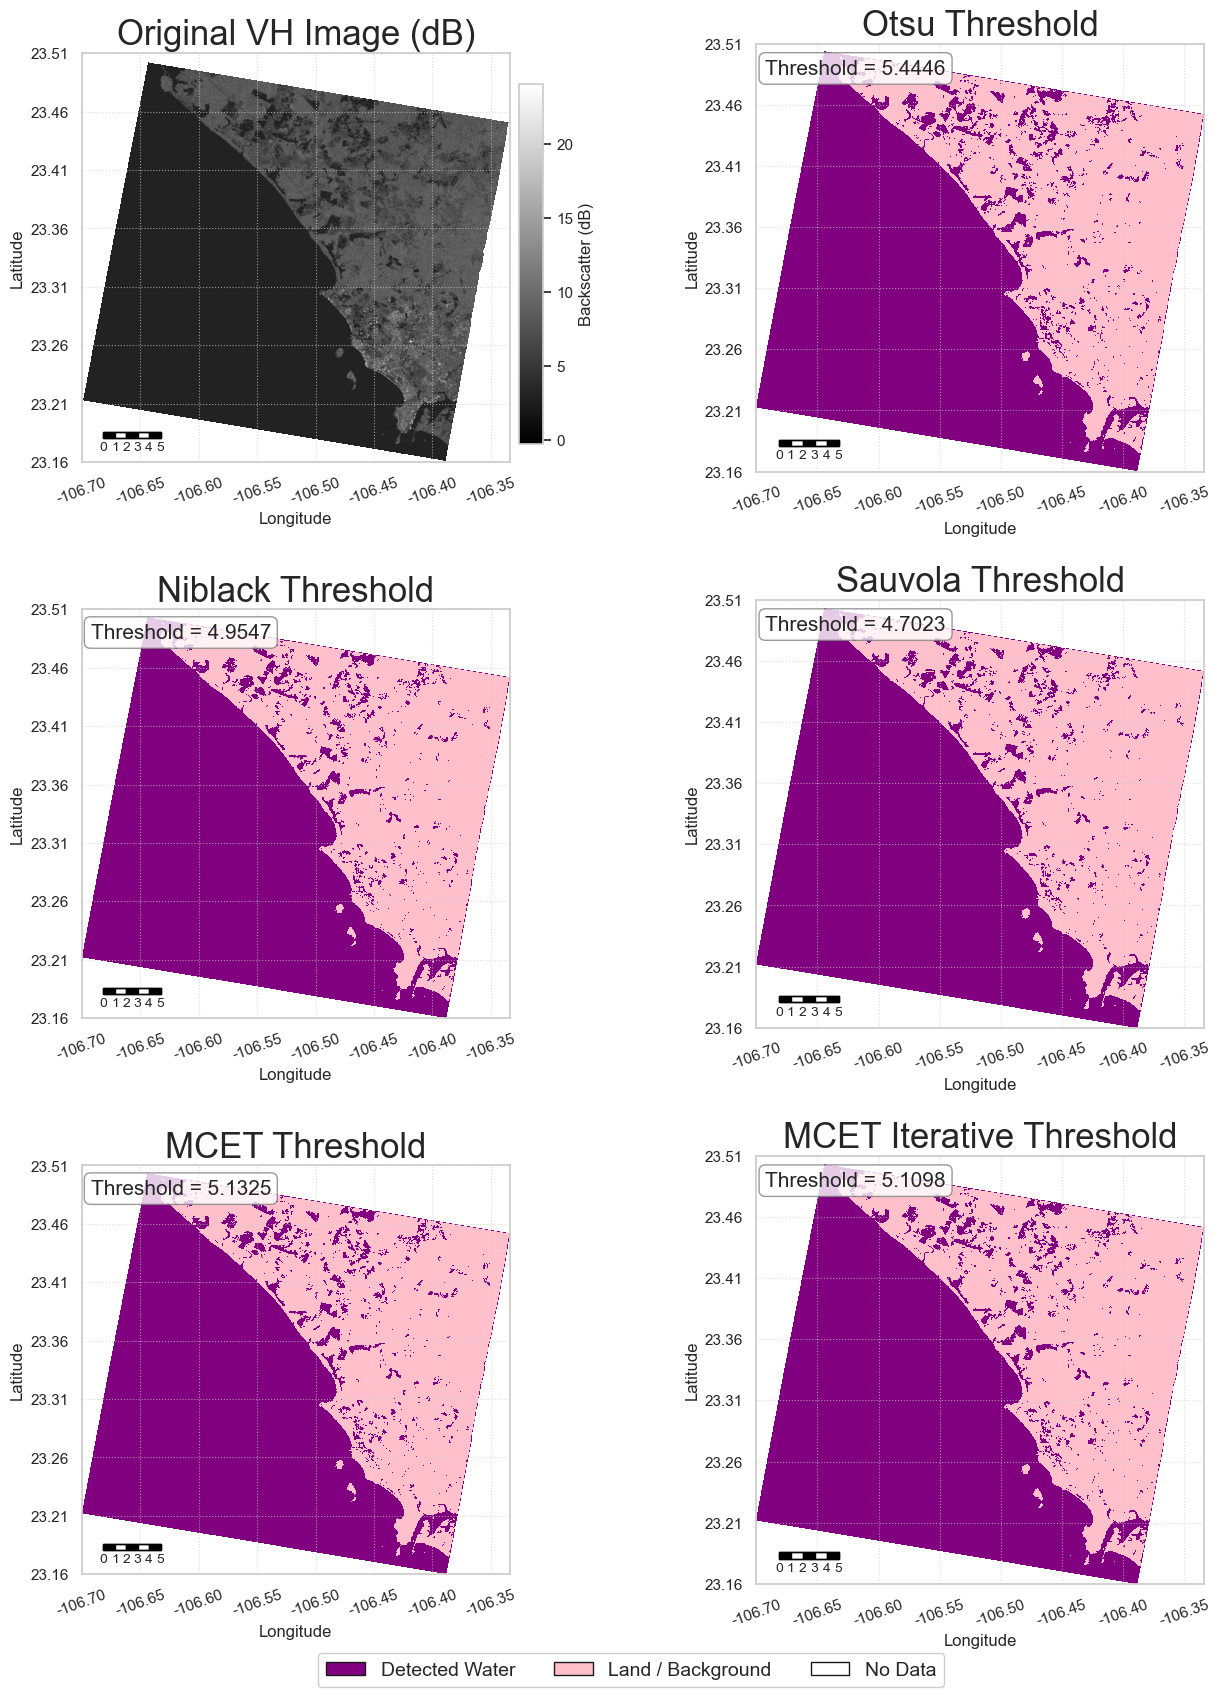

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch, Rectangle
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from skimage.morphology import remove_small_objects
from esa_snappy import GeoPos, PixelPos
import os
import rasterio
from rasterio.transform import from_bounds

# ── PARÁMETROS GENERALES ─────────────────────────────────────
object_size   = 15
sentinel_id   = "VH"
vh_band_name  = "img_db_valid_VH"
titles        = ["Otsu", "Niblack", "Sauvola", "MCET", "MCET Iterative"]

# Colormap ternario (máscaras filtradas)
cmap_masks = ListedColormap(["white", "purple", "pink"])
norm_masks = BoundaryNorm([-1.5, -0.5, 0.5, 1.5], cmap_masks.N)

# Colormap rocket para VH (NaN → blanco)
rocket = sns.color_palette("rocket", as_cmap=True).copy()
rocket.set_bad("white")

# ── FUNCIÓN: barra de escala con marcas cada km ─────────────
def add_bar_scale(ax, extent, total_km=5, segment_km=1,
                  pad_x=0.05, pad_y=0.06,
                  height_frac=0.015, font_size=10):
    """
    Dibuja una barra cartográfica clásica y coloca una etiqueta
    numérica en cada kilómetro (0, 1, 2, … total_km).

    ax        : objeto Axes donde se dibuja
    extent    : [lon_min, lon_max, lat_min, lat_max]
    total_km  : longitud total de la barra (km)
    segment_km: longitud de cada segmento alterno (km)
    """
    lon_min, lon_max, lat_min, lat_max = extent
    lat_c = (lat_min + lat_max) / 2
    m_per_deg_lon = 111_320 * np.cos(np.deg2rad(lat_c))

    seg_deg = segment_km * 1000 / m_per_deg_lon   # ancho de cada segmento (°)
    bar_deg = total_km   * 1000 / m_per_deg_lon   # ancho total   (°)
    bar_ht  = (lat_max - lat_min) * height_frac   # alto de la barra (°)

    # posición (parte inferior-izquierda de la barra)
    x0 = lon_min + (lon_max - lon_min) * pad_x
    y0 = lat_min + (lat_max - lat_min) * pad_y

    # ── dibujar segmentos alternos ───────────────────────────
    n_seg = int(total_km / segment_km)
    for i in range(n_seg):
        xi   = x0 + i * seg_deg
        face = "black" if i % 2 == 0 else "white"
        ax.add_patch(Rectangle((xi, y0), seg_deg, bar_ht,
                               facecolor=face, edgecolor="black",
                               linewidth=1.0, zorder=4))

    # contorno exterior
    ax.add_patch(Rectangle((x0, y0), bar_deg, bar_ht,
                           facecolor="none", edgecolor="black",
                           linewidth=1.0, zorder=4))

    # ── etiquetas numéricas en cada km ───────────────────────
    for km in range(0, total_km + 1, segment_km):
        xi = x0 + km * seg_deg
        ax.text(xi, y0 - bar_ht * 0.55,            # un poco debajo de la barra
                f"{km}",
                ha="center", va="top",
                fontsize=font_size, zorder=5)

# ── FIGURA Y SUBPLOTS ───────────────────────────────────────
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16, 20))
gs = GridSpec(3, 3, figure=fig, width_ratios=[1, 0.03, 1.1], hspace=0.3, wspace=0.15)

# Ejes principales
axes = []
axes.append(fig.add_subplot(gs[0, 0]))  # subplot 0 con colorbar a la derecha
axes.append(fig.add_subplot(gs[0, 2]))  # subplot 1
axes.append(fig.add_subplot(gs[1, 0]))  # subplot 2
axes.append(fig.add_subplot(gs[1, 2]))  # subplot 3
axes.append(fig.add_subplot(gs[2, 0]))  # subplot 4
axes.append(fig.add_subplot(gs[2, 2]))  # subplot 5

# Este eje será para la colorbar de axes[0]
cax0 = fig.add_axes([0.43, 0.68, 0.015, 0.18])# [left, bottom, width, height]

# Forzar aspect ratio = equal para todos-
for ax in axes:
    ax.set_aspect("equal")

# Alinear manualmente los de la izquierda
for idx in [0, 2, 4]:
    pos = axes[idx].get_position()
    center_x = pos.x0 + pos.width / 2
    ref_center = axes[0].get_position().x0 + axes[0].get_position().width / 2
    dx = ref_center - center_x
    new_pos = [pos.x0 + dx, pos.y0, pos.width, pos.height]
    axes[idx].set_position(new_pos)

# ── LECTURA BANDA VH ORIGINAL ───────────────────────────────
band = img_db_product.getBand(vh_band_name)
w, h = band.getRasterWidth(), band.getRasterHeight()
img_db = np.zeros(w * h, dtype=np.float32)
band.readPixels(0, 0, w, h, img_db)
img_db = img_db.reshape((h, w))

# extent geográfico
geo = img_db_product.getSceneGeoCoding()
ul, lr = GeoPos(), GeoPos()
geo.getGeoPos(PixelPos(0, 0),         ul)
geo.getGeoPos(PixelPos(w - 1, h - 1), lr)
extent = [ul.lon, lr.lon, lr.lat, ul.lat]        # lon_min, lon_max, lat_min, lat_max

# ticks y grid cada 0.01°  ------------------------------------
lon_ticks = np.arange(extent[0], extent[1] + 0.01, 0.05)
lat_ticks = np.arange(extent[2], extent[3] + 0.01, 0.05)

def style_axes(ax):
    ax.set_xticks(lon_ticks)
    ax.set_yticks(lat_ticks)
    ax.grid(linestyle=":", linewidth=0.8, alpha=0.7)      # punteada
    ax.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    ax.tick_params(axis="x", labelrotation=20)

# ── SUBPLOT 0 (VH, rocket, colorbar) ────────────────────────
nodata_value = -1                      # ← tu valor nodata real
img_mask = np.ma.masked_where(img_db == nodata_value, img_db)

rocket = sns.color_palette("gray", as_cmap=True).copy()
rocket.set_bad("white")                # los valores enmascarados → blanco

im0 = axes[0].imshow(img_mask, cmap=rocket,
                     vmin=np.nanmin(img_db[img_mask.mask == False]),
                     vmax=np.nanmax(img_db[img_mask.mask == False]),
                     extent=extent, aspect="equal")

# ── Estilo y barra de escala ───────────────────────────────)
style_axes(axes[0])
add_bar_scale(axes[0], extent)
axes[0].set_title("Original VH Image (dB)", fontsize=25)
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

cbar = fig.colorbar(im0, cax=cax0, orientation="vertical")
cbar.set_label("Backscatter (dB)")

# ── BUCLE PRODUCTOS BINARIOS ────────────────────────────────
for i, (nombre, (producto, umbral)) in enumerate(productos_binarios_corrected.items(), start=1):
    band = producto.getBand(f"{nombre}_VH")
    w, h = band.getRasterWidth(), band.getRasterHeight()
    data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, data)
    data = np.round(data.reshape((h, w))).astype(np.int32)

    # genera máscara filtrada
    nodata_mask   = (data == -1)
    data[nodata_mask] = 0
    agua_mask        = (data == 0)
    agua_filtrada    = remove_small_objects(agua_mask, object_size, connectivity=1)
    final_mask       = data.copy()
    final_mask[agua_mask & ~agua_filtrada] = 1
    final_mask[nodata_mask]                = -1

    ax = axes[i]
    ax.imshow(final_mask, cmap=cmap_masks, norm=norm_masks,
              extent=extent, aspect="equal")
    style_axes(ax)
    add_bar_scale(ax, extent)

    ax.set_title(f"{titles[i-1]} Threshold", fontsize=25)
    ax.text(0.02, 0.92, f"Threshold = {umbral:.4f}",
            transform=ax.transAxes, fontsize=15,
            va="bottom",
            bbox=dict(facecolor="white", edgecolor="gray",
                      boxstyle="round,pad=0.3", alpha=0.8))
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # ── Exporta GeoTIFF (sin cambios) ────────────────────────
    export_mask            = final_mask.copy()
    export_mask[final_mask == -1] = -9999
    transform = from_bounds(extent[0], extent[2], extent[1], extent[3], w, h)
    out_tiff = os.path.join(output_directory,
                            f"{sentinel_id}_{nombre}_filtered.tif")
    with rasterio.open(
        out_tiff, "w",
        driver="GTiff",
        height=h, width=w,
        count=1, dtype=rasterio.int16,
        crs="EPSG:4326",
        transform=transform,
        nodata=-9999, compress="lzw"
    ) as dst:
        dst.write(export_mask.astype(rasterio.int16), 1)
    print(f"✅ Exportado: {out_tiff}")

# ── LEYENDA GENERAL ─────────────────────────────────────────
legend_elems = [Patch(facecolor="purple",       edgecolor="k", label="Detected Water"),
                Patch(facecolor="pink", edgecolor="k", label="Land / Background"),
                Patch(facecolor="white",      edgecolor="k", label="No Data")]
fig.legend(handles=legend_elems, loc="upper center", ncol=3, fontsize=14,
           frameon=True, framealpha=1, fancybox=True, bbox_to_anchor=(0.5,0.08))

#plt.tight_layout()#rect=[0.0, 0.0, 1.0, 0.95])
plt.savefig(os.path.join(output_directory, f'{sentinel_id}_ThresholdsFiltered.png'), dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
1=2

SyntaxError: cannot assign to literal (3293032332.py, line 1)

In [ ]:
"""
# ─── 2º ciclo: exportar los GeoTIFF ────────────────────────────────────
for nombre, (mask, w, h, _) in final_masks.items():

    # Convertir -1 a nodata para rasterio
    export_mask          = mask.copy()
    export_mask[mask == -1] = -9999

    transform = from_bounds(extent[0], extent[2], extent[1], extent[3],
                            w, h)
    output_tiff = os.path.join(output_directory,
                               f'{sentinel_id}_{nombre}_filtered.tif')

    with rasterio.open(
        output_tiff, 'w',
        driver='GTiff',
        height=h, width=w,
        count=1, dtype=rasterio.int16,
        crs='EPSG:4326',
        transform=transform,
        nodata=-9999, compress='lzw'
    ) as dst:
        dst.write(export_mask.astype(rasterio.int16), 1)

    print(f"✅ Exportado: {output_tiff}")
"""


'\n# ─── 2º ciclo: exportar los GeoTIFF ────────────────────────────────────\nfor nombre, (mask, w, h, _) in final_masks.items():\n\n    # Convertir -1 a nodata para rasterio\n    export_mask          = mask.copy()\n    export_mask[mask == -1] = -9999\n\n    transform = from_bounds(extent[0], extent[2], extent[1], extent[3],\n                            w, h)\n    output_tiff = os.path.join(output_directory,\n                               f\'{sentinel_id}_{nombre}_filtered.tif\')\n\n    with rasterio.open(\n        output_tiff, \'w\',\n        driver=\'GTiff\',\n        height=h, width=w,\n        count=1, dtype=rasterio.int16,\n        crs=\'EPSG:4326\',\n        transform=transform,\n        nodata=-9999, compress=\'lzw\'\n    ) as dst:\n        dst.write(export_mask.astype(rasterio.int16), 1)\n\n    print(f"✅ Exportado: {output_tiff}")\n'

In [1]:
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape
import numpy as np
import os

def raster_to_shapefile(tiff_path, shapefile_path, target_value=0):
    with rasterio.open(tiff_path) as src:
        image = src.read(1)
        mask = image == target_value  # por ejemplo, agua = 0
        results = (
            {'properties': {'value': v}, 'geometry': s}
            for s, v in shapes(image, mask=mask, transform=src.transform)
        )
        geoms = list(results)
        gdf = gpd.GeoDataFrame.from_features(geoms, crs=src.crs)
        gdf.to_file(shapefile_path)
        print(f"✅ Shapefile saved: {shapefile_path}")


In [3]:
output_tiff_path
#'C:\\Users\\c4cfo\\OneDrive\\CENTROGEO-cfoster\\1_ENSOCE\\thresholdmzt\\6_junio\\VH_flood_li_iter_filtered.tif'

NameError: name 'output_tiff_path' is not defined

In [ ]:
tiff_folder = output_directory#'C:\\Users\\c4cfo\\OneDrive\\CENTROGEO-cfoster\\1_ENSOCE\\thresholdmzt\\6_junio'  # reemplaza con tu carpeta
for nombre in productos.keys():
    tiff_path = os.path.join(tiff_folder, f'{sentinel_id}_{nombre}_filtered.tif')
    shp_path = os.path.join(tiff_folder, f"{sentinel_id}_{nombre}_filtered.shp")
    raster_to_shapefile(tiff_path, shp_path, target_value=1)  # cambiar a 1 si prefieres tierra
    


✅ Shapefile saved: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_otsu_filtered.shp
✅ Shapefile saved: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_niblack_filtered.shp
✅ Shapefile saved: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_sauvola_filtered.shp
✅ Shapefile saved: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_li_filtered.shp
✅ Shapefile saved: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_MCET_iter_filtered.shp


In [ ]:
with rasterio.open(tiff_path) as src:
    pixel_size = src.res[0]  # normalmente res[0] == res[1]
#8.97123884538529e-05  
print(pixel_size*111000) # Convertir a metros (aproximadamente)
buffer_size = pixel_size * 0.5  # de 1 a 2
buffer_size


9.958075118377673


4.485619422692645e-05

In [ ]:
import geopandas as gpd
import os
import rasterio

# Leer tamaño de píxel desde un TIFF de referencia
with rasterio.open(tiff_path) as src:
    pixel_size = src.res[0]  # normalmente igual en x e y

print(f"Tamaño de píxel ≈ {pixel_size*111000:.2f} metros")
buffer_size = pixel_size * 1.25  # puedes ajustar a 0.5 para suavizado sutil

def suavizar_shapefiles_en_carpeta(folder_path, buffer_size=0.00018):
    for file in os.listdir(folder_path):
        if file.endswith(".shp") and "filtered" in file and not file.endswith("_suavizado.shp"):
            shp_path = os.path.join(folder_path, file)
            gdf = gpd.read_file(shp_path)
            print(f"🌀 Suavizando: {file}")
            
            gdf['geometry'] = gdf['geometry'].buffer(buffer_size).buffer(-buffer_size)

            # Crear nuevo nombre con sufijo "_suavizado"
            base_name = file[:-4]  # quitar ".shp"
            new_filename = base_name + "_suavizado.shp"
            new_path = os.path.join(folder_path, new_filename)

            gdf.to_file(new_path)
            print(f"✅ Guardado: {new_path}")

# Ejecutar
suavizar_shapefiles_en_carpeta(tiff_folder, buffer_size=buffer_size)


Tamaño de píxel ≈ 9.96 metros
🌀 Suavizando: VH_flood_li_filtered.shp


C:\Users\c4cfo\AppData\Local\Temp\ipykernel_38420\3496145550.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(buffer_size).buffer(-buffer_size)
C:\Users\c4cfo\AppData\Local\Temp\ipykernel_38420\3496145550.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(buffer_size).buffer(-buffer_size)


✅ Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_li_filtered_suavizado.shp
🌀 Suavizando: VH_flood_MCET_iter_filtered.shp
✅ Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_MCET_iter_filtered_suavizado.shp
🌀 Suavizando: VH_flood_niblack_filtered.shp


C:\Users\c4cfo\AppData\Local\Temp\ipykernel_38420\3496145550.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(buffer_size).buffer(-buffer_size)
C:\Users\c4cfo\AppData\Local\Temp\ipykernel_38420\3496145550.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(buffer_size).buffer(-buffer_size)


✅ Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_niblack_filtered_suavizado.shp
🌀 Suavizando: VH_flood_otsu_filtered.shp
✅ Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_otsu_filtered_suavizado.shp
🌀 Suavizando: VH_flood_sauvola_filtered.shp
✅ Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_sauvola_filtered_suavizado.shp


C:\Users\c4cfo\AppData\Local\Temp\ipykernel_38420\3496145550.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(buffer_size).buffer(-buffer_size)


In [ ]:
import geopandas as gpd
import os
import rasterio

# Leer tamaño de píxel desde un TIFF de referencia
with rasterio.open(tiff_path) as src:
    pixel_size = src.res[0]  # normalmente igual en x e y

print(f"Tamaño de píxel ≈ {pixel_size*111000:.2f} metros")
simplify_tolerance = pixel_size * 0.7  # tolerancia sutil (~5 m si pixel_size ≈ 10 m)

def suavizar_shapefiles_en_carpeta(folder_path, tolerance=0.00005):
    for file in os.listdir(folder_path):
        if file.endswith(".shp") and "filtered" in file and not file.endswith("_suavizado.shp"):
            shp_path = os.path.join(folder_path, file)
            gdf = gpd.read_file(shp_path)
            print(f"🌀 Suavizando (simplify): {file}")
            
            # Aplicar simplify (más respetuoso con diagonales)
            gdf['geometry'] = gdf['geometry'].simplify(tolerance=tolerance, preserve_topology=True)

            # Crear nuevo nombre con sufijo "_suavizado"
            base_name = file[:-4]  # quitar ".shp"
            new_filename = base_name + "_suavizado.shp"
            new_path = os.path.join(folder_path, new_filename)

            gdf.to_file(new_path)
            print(f"✅ Guardado: {new_path}")

# Ejecutar
suavizar_shapefiles_en_carpeta(tiff_folder, tolerance=simplify_tolerance)


Tamaño de píxel ≈ 9.96 metros
🌀 Suavizando (simplify): VH_flood_li_filtered.shp
✅ Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_li_filtered_suavizado.shp
🌀 Suavizando (simplify): VH_flood_MCET_iter_filtered.shp
✅ Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_MCET_iter_filtered_suavizado.shp
🌀 Suavizando (simplify): VH_flood_niblack_filtered.shp
✅ Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_niblack_filtered_suavizado.shp
🌀 Suavizando (simplify): VH_flood_otsu_filtered.shp
✅ Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_otsu_filtered_suavizado.shp
🌀 Suavizando (simplify): VH_flood_sauvola_filtered.shp
✅ Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_sauvola_filtered_suavizado.shp


In [ ]:
import geopandas as gpd
import os
import rasterio

# Leer tamaño de píxel desde un TIFF de referencia
with rasterio.open(tiff_path) as src:
    pixel_size = src.res[0]  # grados

print(f"Tamaño de píxel ≈ {pixel_size*111000:.2f} metros")
simplify_tolerance = pixel_size * 0.7  # ~5 metros
buffer_amount = pixel_size * 0.1       # ~2 metros

def suavizar_shapefiles_en_carpeta(folder_path, tolerance, buffer_val):
    for file in os.listdir(folder_path):
        if file.endswith(".shp") and "filtered" in file and not file.endswith("_suavizado.shp"):
            shp_path = os.path.join(folder_path, file)
            gdf = gpd.read_file(shp_path)
            print(f"🌀 Suavizando (simplify + buffer): {file}")

            # Paso 1: simplify para mantener bordes limpios
            gdf['geometry'] = gdf['geometry'].simplify(tolerance=tolerance, preserve_topology=True)

            # Paso 2: buffer suave para redondear dientes
            gdf['geometry'] = gdf['geometry'].buffer(buffer_val).buffer(-buffer_val)

            # Crear nuevo nombre con sufijo "_suavizado"
            base_name = file[:-4]
            new_filename = base_name + "_suavizado.shp"
            new_path = os.path.join(folder_path, new_filename)

            gdf.to_file(new_path)
            print(f"✅ Guardado: {new_path}")

# Ejecutar
suavizar_shapefiles_en_carpeta(tiff_folder, tolerance=simplify_tolerance, buffer_val=buffer_amount)


Tamaño de píxel ≈ 9.96 metros
🌀 Suavizando (simplify + buffer): VH_flood_li_filtered.shp
✅ Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_li_filtered_suavizado.shp
🌀 Suavizando (simplify + buffer): VH_flood_MCET_iter_filtered.shp
✅ Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_MCET_iter_filtered_suavizado.shp
🌀 Suavizando (simplify + buffer): VH_flood_niblack_filtered.shp


C:\Users\c4cfo\AppData\Local\Temp\ipykernel_38420\3141321949.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(buffer_val).buffer(-buffer_val)
C:\Users\c4cfo\AppData\Local\Temp\ipykernel_38420\3141321949.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(buffer_val).buffer(-buffer_val)
C:\Users\c4cfo\AppData\Local\Temp\ipykernel_38420\3141321949.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(buffer_val).buffer(-buffer_val)


✅ Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_niblack_filtered_suavizado.shp
🌀 Suavizando (simplify + buffer): VH_flood_otsu_filtered.shp
✅ Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_otsu_filtered_suavizado.shp
🌀 Suavizando (simplify + buffer): VH_flood_sauvola_filtered.shp
✅ Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_sauvola_filtered_suavizado.shp


C:\Users\c4cfo\AppData\Local\Temp\ipykernel_38420\3141321949.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(buffer_val).buffer(-buffer_val)
C:\Users\c4cfo\AppData\Local\Temp\ipykernel_38420\3141321949.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(buffer_val).buffer(-buffer_val)


In [ ]:
import geopandas as gpd
import os
import rasterio

# Leer tamaño de píxel desde un TIFF de referencia
with rasterio.open(tiff_path) as src:
    pixel_size = src.res[0]

print(f"Tamaño de píxel ≈ {pixel_size*111000:.2f} metros")
simplify_tolerance = pixel_size * 0.7
buffer_amount = pixel_size * 0.1

def suavizar_y_guardar_como_polilinea(folder_path, tolerance, buffer_val):
    for file in os.listdir(folder_path):
        if file.endswith(".shp") and "filtered" in file and not file.endswith("_suavizado_linea.shp"):
            shp_path = os.path.join(folder_path, file)
            gdf = gpd.read_file(shp_path)
            print(f"🌀 Suavizando y convirtiendo a línea: {file}")

            # Paso 1: simplify
            gdf['geometry'] = gdf['geometry'].simplify(tolerance=tolerance, preserve_topology=True)

            # Paso 2: buffer
            gdf['geometry'] = gdf['geometry'].buffer(buffer_val).buffer(-buffer_val)

            # Paso 3: convertir a línea
            gdf['geometry'] = gdf['geometry'].boundary

            # Crear nuevo nombre
            base_name = file[:-4]
            new_filename = base_name + "_suavizado_linea.shp"
            new_path = os.path.join(folder_path, new_filename)

            # Guardar como shapefile de líneas
            gdf.to_file(new_path)
            print(f"✅ Guardado como línea: {new_path}")

# Ejecutar
suavizar_y_guardar_como_polilinea(tiff_folder, tolerance=simplify_tolerance, buffer_val=buffer_amount)


Tamaño de píxel ≈ 9.96 metros
🌀 Suavizando y convirtiendo a línea: VH_flood_li_filtered.shp
✅ Guardado como línea: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_li_filtered_suavizado_linea.shp
🌀 Suavizando y convirtiendo a línea: VH_flood_li_filtered_suavizado.shp


C:\Users\c4cfo\AppData\Local\Temp\ipykernel_38420\2906371809.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(buffer_val).buffer(-buffer_val)
C:\Users\c4cfo\AppData\Local\Temp\ipykernel_38420\2906371809.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(buffer_val).buffer(-buffer_val)


✅ Guardado como línea: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_li_filtered_suavizado_suavizado_linea.shp
🌀 Suavizando y convirtiendo a línea: VH_flood_MCET_iter_filtered.shp
✅ Guardado como línea: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_MCET_iter_filtered_suavizado_linea.shp
🌀 Suavizando y convirtiendo a línea: VH_flood_MCET_iter_filtered_suavizado.shp
✅ Guardado como línea: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_MCET_iter_filtered_suavizado_suavizado_linea.shp
🌀 Suavizando y convirtiendo a línea: VH_flood_niblack_filtered.shp


C:\Users\c4cfo\AppData\Local\Temp\ipykernel_38420\2906371809.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(buffer_val).buffer(-buffer_val)
C:\Users\c4cfo\AppData\Local\Temp\ipykernel_38420\2906371809.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(buffer_val).buffer(-buffer_val)
C:\Users\c4cfo\AppData\Local\Temp\ipykernel_38420\2906371809.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(buffer_val).buffer(-buffer_val)
C:\Users\c4cfo\AppData

✅ Guardado como línea: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_niblack_filtered_suavizado_linea.shp
🌀 Suavizando y convirtiendo a línea: VH_flood_niblack_filtered_suavizado.shp
✅ Guardado como línea: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_niblack_filtered_suavizado_suavizado_linea.shp
🌀 Suavizando y convirtiendo a línea: VH_flood_otsu_filtered.shp
✅ Guardado como línea: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_otsu_filtered_suavizado_linea.shp
🌀 Suavizando y convirtiendo a línea: VH_flood_otsu_filtered_suavizado.shp


C:\Users\c4cfo\AppData\Local\Temp\ipykernel_38420\2906371809.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(buffer_val).buffer(-buffer_val)
C:\Users\c4cfo\AppData\Local\Temp\ipykernel_38420\2906371809.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(buffer_val).buffer(-buffer_val)


✅ Guardado como línea: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_otsu_filtered_suavizado_suavizado_linea.shp
🌀 Suavizando y convirtiendo a línea: VH_flood_sauvola_filtered.shp
✅ Guardado como línea: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_sauvola_filtered_suavizado_linea.shp
🌀 Suavizando y convirtiendo a línea: VH_flood_sauvola_filtered_suavizado.shp
✅ Guardado como línea: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\8_agosto\VH_flood_sauvola_filtered_suavizado_suavizado_linea.shp


C:\Users\c4cfo\AppData\Local\Temp\ipykernel_38420\2906371809.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf['geometry'].buffer(buffer_val).buffer(-buffer_val)


In [ ]:

"""
##---------------------------------------
# 1) Abrir el GeoTIFF en modo solo-lectura
tif_path = final_tif
ds = gdal.Open(tif_path, gdal.GA_ReadOnly)
band = ds.GetRasterBand(1)

# 2) Leer la banda a un array float32
glcm = band.ReadAsArray().astype(np.float32)

# 3) Manejar NoData → NaN
nodata = band.GetNoDataValue()      # debería devolver -9999.0
if nodata is not None:
    glcm[glcm == nodata] = np.nan   # así tu histograma ignora nodata

# 4) ¡Listo!  →  Llamar a la función
thresholds, scores = histograma_threshold_metrics(glcm)
#---------------------------------------------------------
    
for nombre, producto in productos_binarios_corrected.items():
    # Generar sufijos personalizados para cada nombre de producto
    suffix_base = f"_{nombre}_corrected"

    # Generar rutas de salida usando tus funciones reutilizables
    raster_path = clf.generate_raster_path(sentinel_1_path, output_directory)
    shapefile_path = clf.generate_shapefile_path(sentinel_1_path, output_directory)

    print(f"Procesando producto corregido: {nombre}")
    
    # Exportar raster y shapefile
    #clf.exportar_raster_y_shapefile(producto, raster_path, shapefile_path)
"""


"""
for nombre, producto in productos_binarios_corrected.items():
    output_path = os.path.join(output_directory, f"{sentinel_id}_{nombre}_corrected.tif")  
    shape_path = os.path.join(output_directory, f"{sentinel_id}_{nombre}_corrected.shp")  
    print(f"Guardando producto corregido: {output_path}")
    #ProductIO.writeProduct(producto, output_path, "GeoTIFF")  # o "GeoTIFF" si prefieres tif
"""
#extent=[-106.52, -106.41, 23.17, 23.27]


'\nfor nombre, producto in productos_binarios_corrected.items():\n    output_path = os.path.join(output_directory, f"{sentinel_id}_{nombre}_corrected.tif")  \n    shape_path = os.path.join(output_directory, f"{sentinel_id}_{nombre}_corrected.shp")  \n    print(f"Guardando producto corregido: {output_path}")\n    #ProductIO.writeProduct(producto, output_path, "GeoTIFF")  # o "GeoTIFF" si prefieres tif\n'